#### Code

In [1]:
from numba import jit, cuda
import warnings
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import time as timess
from prettytable import PrettyTable
from IPython.display import clear_output
base_noise_min=-0.005
base_noise_max= 0.005

time=[]
# for i in range(-1,200000):
for i in range(-1,1000000):
    time.append(i)           # 1 nano second resolution
ci=0#len(time)//4
cf=len(time)//1

fig_x , fig_y = 25 , 2
clrs= 'rgbcmyk'

In [2]:
# rf = open("Radar_G_table.txt", "w")
# f = open("G_table.txt", "w")
# for j in range(5,185,5):
#     f.write(str(j/10))
#     f.write(' | ')
#     rf.write(str(j/10))
#     rf.write(' | ')
#     for i in range(360):
#         if((i>=0 and i<=90) or (i>=270 and i<360)):
#             f.write(str(math.cos(math.radians(i)))+' ')
#             rf.write(str(math.cos(math.radians(i)))+' ')
#         else:
#             f.write(str(0)+' ')
#             rf.write(str(0)+' ')
#     f.write('\n')
#     rf.write('\n')
# f.close()    
# rf.close()    

G_table={}
f = open("G_table_2d.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    G_table[tmp_freq]=[]
    for i in tmp:
        G_table[tmp_freq].append(float(i))
f.close()

Radar_G_table={}
f = open("Radar_G_table_2d.txt", "r")
Lines = f.readlines()
for line in Lines:
    tmp=list(line.split())
    tmp_freq=float(tmp[0])
    tmp=tmp[2:]
    Radar_G_table[tmp_freq]=[]
    for i in tmp:
        Radar_G_table[tmp_freq].append(float(i))
f.close()

In [3]:
def interleave(pulses,display=1):
    global ci,cf,fig_x,fig_y,clrs,base_noise_max
    jdx=0
    ylim=0.6
    pulse_f=[]
    for j in range(len(pulses)):
        pulse_f.append([])
        for i in time:
            if (j!=len(pulses)-1):
                max_t=[]
                for k in pulses[j]:
                    max_t.append(k[i] if k[i]> base_noise_max else 0)
                pulse_f[-1].append(max(max_t))
                # pulse_f[-1].append(sum(max_t))
            else:
                max_t=set()
                for k in pulses[j]:
                    max_t.add(k[i])
                if(0 in max_t):
                    if(len(max_t)>2):
                        pulse_f[-1].append(0)
                    else:
                        pulse_f[-1].append(max(max_t))
                else:
                    if(len(max_t)>1):
                        pulse_f[-1].append(0)
                    else:
                        pulse_f[-1].append(max(max_t))
        if(display==1 and j!=len(pulses)-1):
            jdx+=1
            print(jdx)
            plt.figure(figsize=(fig_x , fig_y))
            idx=0
            for i in pulses[j]:
                idx+=1
                plt.plot(time[ci:cf],i[ci:cf], color=clrs[idx-1], label=str(idx))
            plt.legend()
            plt.xlabel("independent input pulses")
            plt.ylim([0, ylim])
            # plt.savefig("independent"+str(jdx)+".jpg")
            plt.show()
            plt.figure(figsize=(fig_x , fig_y))
            plt.plot(time[ci:cf],pulse_f[-1][ci:cf], color='r')
            plt.xlabel("interleaved pulses")
            plt.ylim([0, ylim])
            # plt.savefig("interleaved"+str(jdx)+".jpg")
            plt.show()
        elif(display==3 and j!=len(pulses)-1):
            jdx+=1
            print(jdx)
            plt.figure(figsize=(fig_x , fig_y))
            idx=0
            for i in pulses[j]:
                idx+=1
                plt.plot(time[ci:cf],i[ci:cf], color=clrs[idx-1], label=str(idx))
            plt.legend()
            plt.xlabel("independent input pulses")
            plt.ylim([0, ylim])
            plt.savefig("independent"+str(jdx)+".jpg")
            plt.show()
    if(display==2):
        idx=0
        for i in pulse_f[:-1]:
            idx+=1
            print(idx)
            plt.figure(figsize=(fig_x , fig_y))
            plt.plot(time[ci:cf],i[ci:cf], color='r')
            plt.xlabel("interleaved pulses")
            plt.ylim([0, ylim])
            # plt.savefig("interleaved"+str(idx)+".jpg")
            plt.show()
    return pulse_f

In [4]:
class reciever:
    def __init__(self, id,radar,aircraft):
        global G_table,base_noise_min,base_noise_max,time,receivers_n,rwr_antenna_n
        self.id = id                                       # Id of the reciever
        self.pri = radar.pri                               # Pulse Repetition Interval
        self.pwd = radar.pwd                               # Pulse Width
        self.R = math.dist(radar.pos,aircraft.pos)         # Distance between the radar and the aircraft
        self.Pt = radar.Pt                                 # Peak transmitted power
        self.freq = radar.freq                             # carrier frequency
        # Lambda=3*(10**8)/radar.freq
        Lambda=2
        angle=math.degrees(math.atan2(radar.pos[1]-aircraft.pos[1],radar.pos[0]-aircraft.pos[0]))-aircraft.heading
        while(angle>=360):
            angle-=360                                     # Angle between the aircraft's front direction and radar
        while(angle<0):
            angle+=360
        self.angle = angle
        angle_rad = radar.heading
        angle_t=int(angle-angle_rad-180-(360-aircraft.heading))
        while(angle_t>=360):
            angle_t-=360                                     # Angle between the radar's boresight and aircraft
        while(angle_t<0):
            angle_t+=360
        self.angle_radar = angle_t
        self.P=(self.Pt*Radar_G_table[self.freq][angle_t]*(Lambda**2))/((4*math.pi*self.R)**2)  # Power recieved by the aircraft radar reciver
        a=0.1
        omega=2*np.pi*self.freq/2000
        angl_cond=[]
        loss=8
        self.pulse_train_angles=[]
        self.pulse_train=[]                                   # we are producing the pulse train for the 4 recievers
        for j in range(receivers_n):                          # front left, rear left, rear right and front right respectively
            angl_cond.append((360/receivers_n)*(1+2*j)/2)     # based on the above information
            self.pulse_train.append([])
        for j in range(rwr_antenna_n-receivers_n):
            self.pulse_train.append([])
        for i in range(-1,len(time)-1):
            if(i%self.pri<=self.pwd):
                self.pulse_train_angles.append(angle)
                # idx=0
                # for j in self.pulse_train:
                #     tmp_n=random.uniform(base_noise_min,base_noise_max)
                #     tmp_v=abs(self.P*G_table[self.freq][int(angle-angl_cond[idx])])
                #     j.append(tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1)))
                #     idx+=1
                idx=0
                off_set=0
                while (idx < receivers_n):
                    tmp_n=random.uniform(base_noise_min,base_noise_max)
                    tmp_v=abs(self.P*G_table[self.freq][int(angle-angl_cond[idx])])
                    if(angl_cond[idx]-90<0):
                        j=self.pulse_train[idx+off_set]
                        j.append(tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1)))
                        if(rwr_antenna_n!=receivers_n):
                            off_set+=1
                            if(angle>=angl_cond[idx]+270 and angle<=360):
                                tmp_v=tmp_v/(((360-angle)*loss/45)+2)
                            j=self.pulse_train[idx+off_set]
                            j.append(tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1)))
                    elif(angl_cond[idx]+90>360):
                        if(rwr_antenna_n!=receivers_n):
                            if (angle>=1 and angle<=angl_cond[idx]-270):
                                tmp_v=tmp_v/((angle*loss/45)+2)
                            j=self.pulse_train[idx+off_set]
                            j.append(tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1)))
                            off_set+=1
                        tmp_v=abs(self.P*G_table[self.freq][int(angle-angl_cond[idx])])
                        j=self.pulse_train[idx+off_set]
                        j.append(tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1)))
                    else:
                        j=self.pulse_train[idx+off_set]
                        j.append(tmp_n if tmp_v<base_noise_max else tmp_v*(1+a*(np.sin(omega*i)-1)))
                    idx+=1
            else:
                self.pulse_train_angles.append(0)
                # for j in self.pulse_train:
                #     j.append(random.uniform(base_noise_min,base_noise_max))
                idx=0
                while (idx <rwr_antenna_n):
                    j=self.pulse_train[idx]
                    j.append(random.uniform(base_noise_min,base_noise_max))
                    idx+=1
    def __del__(self):
        pass
            
class radar:
    def __init__(self, id,pri=500,pwd=10,pos=(0,0),heading=0):
        self.id = id                                       # Id of the radar
        self.pri = pri                                     # Pulse Repetition Interval 1 nano seconds
        self.pwd = pwd                                     # Pulse Width in 1 nano seconds
        self.Pt = 20                                       # Peak transmitted power
        self.freq = 0.5                                    # frequency range 0.5 to 18 units gigahertz
        self.heading = heading                             # heading of the radar in degrees
        self.pos = pos
    def __del__(self):
        pass
class aircraft:
    def __init__(self, id,pos=(0,0),heading=0,receivers=4):
        self.id = id                                       # Id of the Aircraft
        self.pos = pos                                     # Position of the radar
        self.heading = heading                             # heading of the Aircraft in degrees
        self.receivers_n = receivers                       # Number of antenna's in the RWR
    def __del__(self):
        pass

#### Code

In [5]:
rwr_antenna_n = 4              # Number of recievers on the aircraft(4 or 6)
radars_n = 3                   # Number of radars

radar_positions=[]
rad_range=[1,2]
for i in range(radars_n):
    radar_positions.append((random.uniform(rad_range[0],rad_range[1]) if random.uniform(-1,1)>0 else random.uniform(-rad_range[0],-rad_range[1]),
                            random.uniform(rad_range[0],rad_range[1]) if random.uniform(-1,1)>0 else random.uniform(-rad_range[0],-rad_range[1])))
radar_positions = np.array(radar_positions)

radar_positions = np.array([
    # (1,0),
    (1,-0.2),
    (1,0.2),
    # (2,0),
    # (-1,1),
    # (-1,0),
    # (-1,-1),
    # (0,-1),
    # (1,-1),
])
radars_n=len(radar_positions)
receivers_n = 4 # Effective number of antenna
# aircraft_0 = aircraft(id=0,pos=(0,0),heading=0,receivers=random.uniform(0,360))
aircraft_0 = aircraft(id=0,pos=(0,0),heading=0,receivers=0)
# aircraft_0 = aircraft(id=0,pos=(random.uniform(-1,1),random.uniform(-1,1)),heading=random.uniform(0,360),receivers=receivers_n)

radars=[]
pulses=[]                                   
for i in range(rwr_antenna_n+1):                          
    pulses.append([])

for j in range(radars_n):
    heading_angle=int(math.degrees(math.atan2(aircraft_0.pos[1]-radar_positions[j][1],aircraft_0.pos[0]-radar_positions[j][0])))#+180
    heading_noise_range=0
    rand_pri=int(np.random.normal(loc=150000, scale=70000, size=(1))[0])
    if(rand_pri<50000):
        rand_pri=50000
    elif(rand_pri>250000):
        rand_pri=250000
    radar_j = radar(id=j,pri=rand_pri,pwd=8000,pos=radar_positions[j],heading=random.randint(heading_angle-heading_noise_range,heading_angle+heading_noise_range))
    pulse_j = reciever(id=j,radar=radar_j,aircraft=aircraft_0)
    radars.append(radar_j)
    for i in range(rwr_antenna_n):
        pulses[i].append(pulse_j.pulse_train[i])
    pulses[rwr_antenna_n].append(pulse_j.pulse_train_angles)
    del radar_j;
    del pulse_j;
    
tmp_s_r=0.2    
tmp_x_r=[]   
tmp_y_r=[]                        
for i in radars:
    tmp_x_r.append(i.pos[0]+(tmp_s_r*math.cos(math.radians(i.heading))))
    tmp_y_r.append(i.pos[1]+(tmp_s_r*math.sin(math.radians(i.heading))))
tmp_s_a=0.3
tmp_x_a=[]
tmp_y_a=[]
tmp_x_am=[]
tmp_y_am=[]
airc_head_x=aircraft_0.pos[0]+(tmp_s_a*math.cos(math.radians(aircraft_0.heading)))
airc_head_y=aircraft_0.pos[1]+(tmp_s_a*math.sin(math.radians(aircraft_0.heading)))
for j in range(receivers_n):
    tmp_x_a.append(aircraft_0.pos[0])
    tmp_y_a.append(aircraft_0.pos[1])
    tmp_x_a.append(aircraft_0.pos[0]+(tmp_s_a*math.cos(math.radians(aircraft_0.heading+(360/receivers_n)*(1+2*j)/2))))
    tmp_y_a.append(aircraft_0.pos[1]+(tmp_s_a*math.sin(math.radians(aircraft_0.heading+(360/receivers_n)*(1+2*j)/2))))
if(receivers_n!=rwr_antenna_n):
    tmp_x_a.append(aircraft_0.pos[0])
    tmp_y_a.append(aircraft_0.pos[1])
    for j in range(receivers_n):
        if(j==0 or j==receivers_n-1):
            tmp_x_a.append(airc_head_x)
            tmp_y_a.append(airc_head_y)
            tmp_x_a.append(airc_head_x+(tmp_s_a*math.cos(math.radians(aircraft_0.heading+(360/receivers_n)*(1+2*j)/2))))
            tmp_y_a.append(airc_head_y+(tmp_s_a*math.sin(math.radians(aircraft_0.heading+(360/receivers_n)*(1+2*j)/2))))

#### Aircraft and Radar Positions

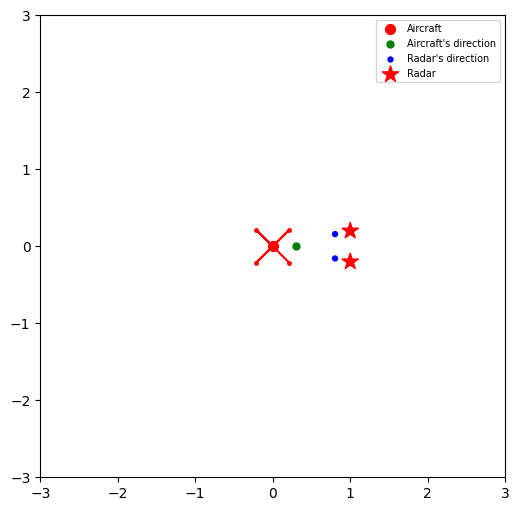

In [6]:
plt.figure(figsize=(6 , 6))
plt.plot(tmp_x_a,tmp_y_a, color='r', marker = '.', markersize=5)
plt.scatter(aircraft_0.pos[0],aircraft_0.pos[1],[200], color='r', marker = '.',label='Aircraft')
plt.scatter(airc_head_x,airc_head_y,[100], color='g', marker = '.',label='Aircraft\'s direction')
plt.scatter(tmp_x_r,tmp_y_r,[50]*len(tmp_x_r), color='b', marker = '.',label='Radar\'s direction')
plt.scatter(radar_positions[:,0],radar_positions[:,1],[150]*len(radar_positions), color='r', marker = '*',label='Radar')
plt.legend(fontsize = 7)
rng=3
for i in radar_positions:
    for j in i:
        if(rng<(abs(j)+1)):
            rng=abs(j)+1
plt.xlim([-rng, rng])
plt.ylim([-rng, rng])
# plt.savefig("main.jpg")
plt.show()

#### Simulated pulse trains received by the RWR antennas

Aircraft and it's description
+----+-------------------------+
| Id | Number of RWR antenna's |
+----+-------------------------+
| 1  |            0            |
+----+-------------------------+
Radars and their description
+----+------------------------+-----------+---------------------------+-------------+
| Id | Peak transmitted power | frequency | Pulse Repetition Interval | Pulse Width |
+----+------------------------+-----------+---------------------------+-------------+
| 1  |           20           |    0.5    |           250000          |     8000    |
| 2  |           20           |    0.5    |           141685          |     8000    |
+----+------------------------+-----------+---------------------------+-------------+
1


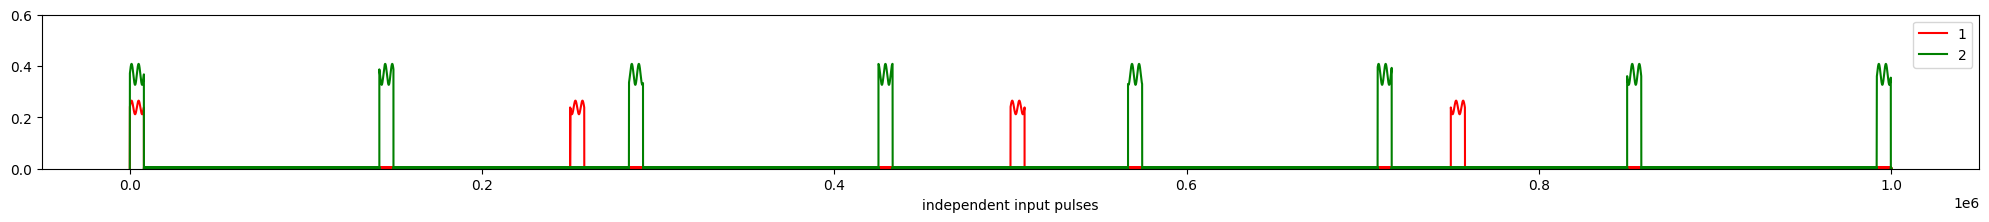

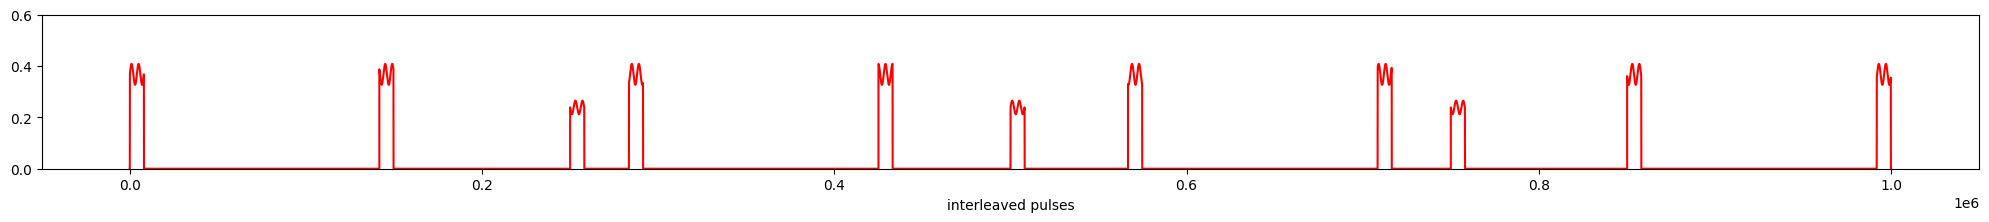

2


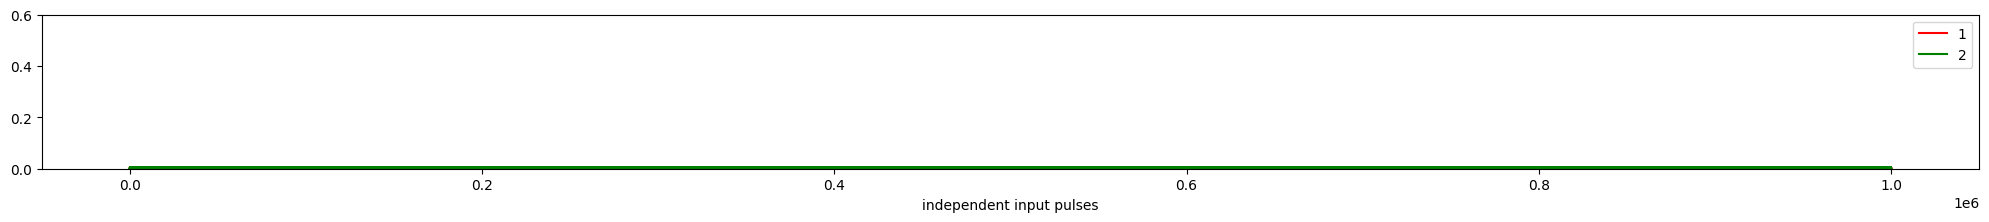

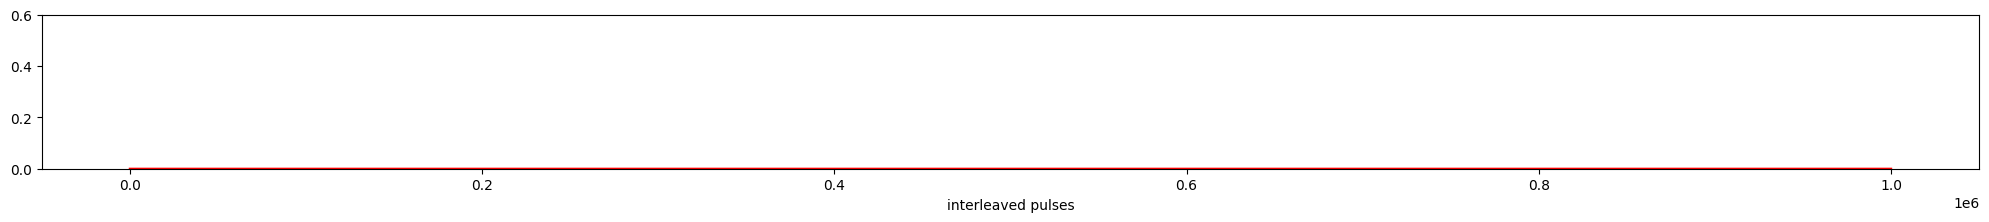

3


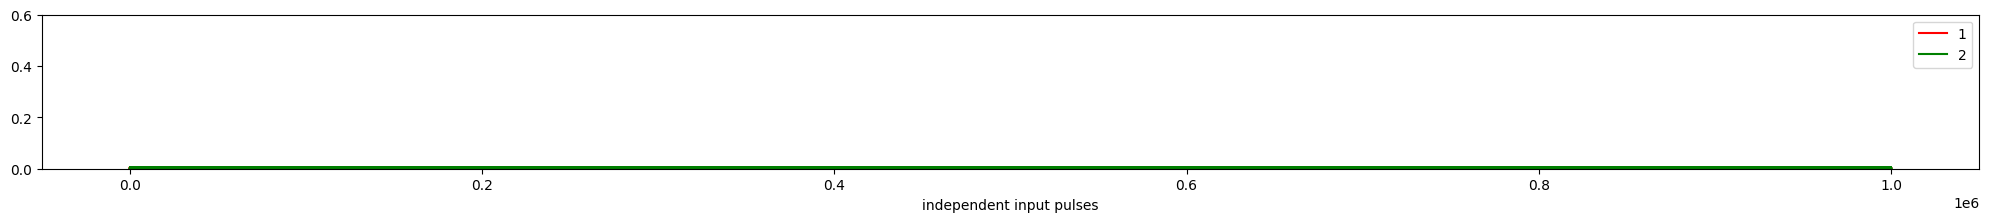

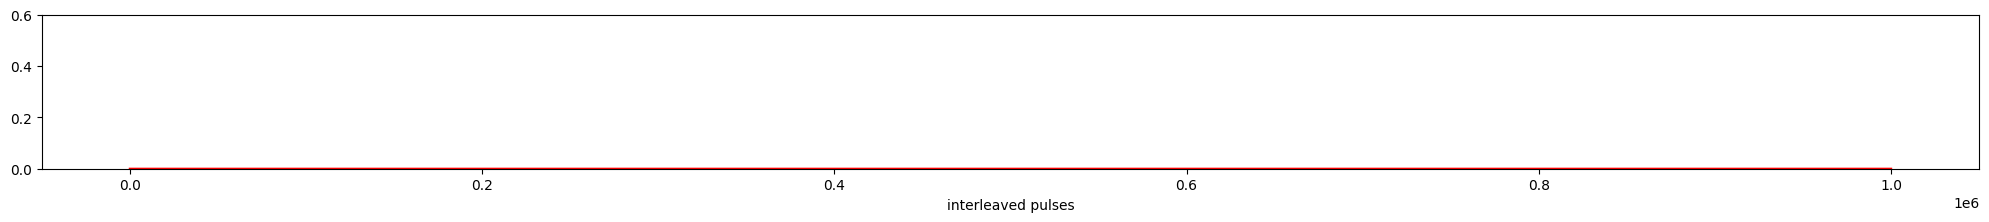

4


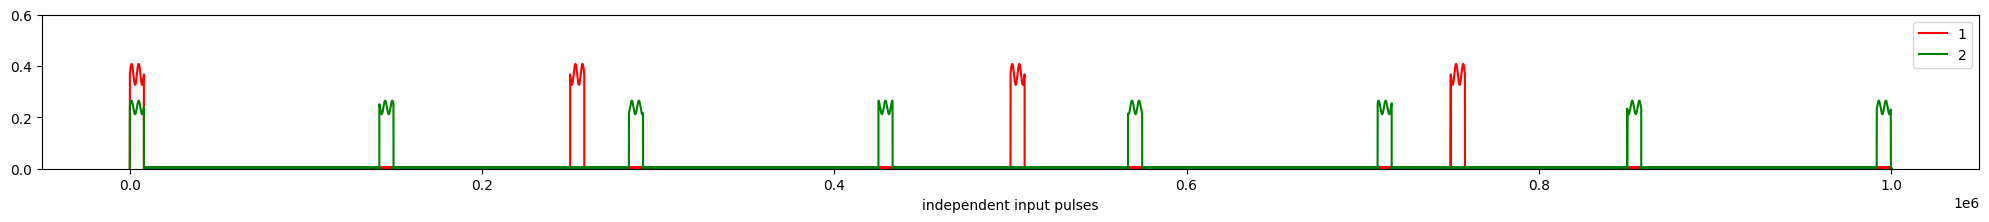

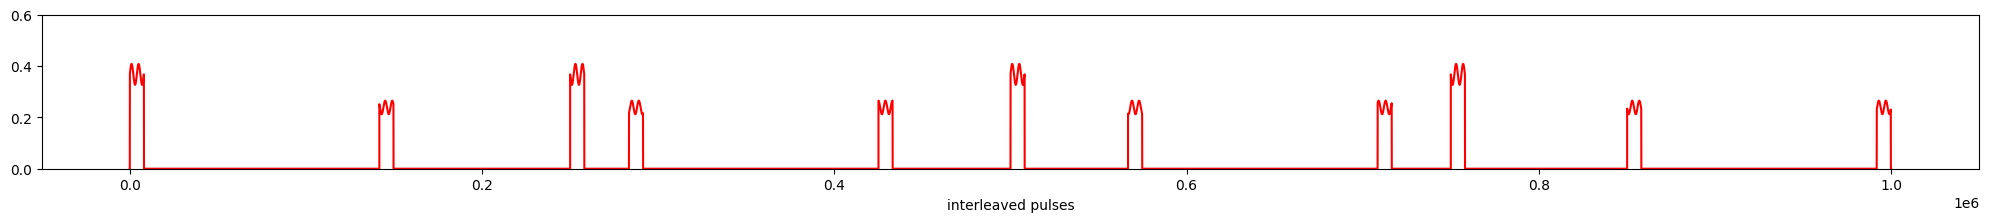

In [7]:
# print('Radars and their description')
# for i in radars:
#     print('---------------------')
#     print('Id                        -',i.id+1)
#     print('Position                  -',tuple(i.pos))
#     print('Peak transmitted power    -',i.Pt)
#     print('frequency                 -',i.freq)
#     print('Pulse Repetition Interval -',i.pri)
#     print('Pulse Width               -',i.pwd)
# print('---------------------')

print('Aircraft and it\'s description')
t = PrettyTable(['Id','Number of RWR antenna\'s'])
i=aircraft_0
t.add_row([i.id+1,i.receivers_n])
print(t)
print('Radars and their description')
t = PrettyTable(['Id', 'Peak transmitted power','frequency','Pulse Repetition Interval','Pulse Width'])
for i in radars:
    t.add_row([i.id+1,i.Pt,i.freq,i.pri,i.pwd])
print(t)
interleaved_pulse_train=interleave(pulses,display=1)


#### Code

In [8]:
def pdw(pulse_f,display=1):
    global time,ci,cf,fig_x,fig_y,clrs,base_noise_max
    # ci=121200
    # cf=129300
    pdw=[]
    idx=0
    for i in pulse_f[:-1]:
        if(display):
            idx+=1
            print(idx)
            plt.figure(figsize=(fig_x , fig_y))
            plt.plot(time[ci:cf],i[ci:cf], color='r')
            plt.xlabel("interleaved pulses")
            plt.show()
    tmp_pdw={}
    counter=[]
    max_amplitude=[]
    max_amplitude_t=[]
    list_init=[]
    fall_flag=[]
    lead_flag=[]
    increasing_count=[]
    increasing_flag=[]
    top_points=[]
    for j in pulse_f[:-1]:
        counter.append(0)
        max_amplitude.append(0)
        max_amplitude_t.append(0)
        increasing_count.append(0)
        list_init.append([])
        top_points.append([])
        increasing_flag.append(0)
        fall_flag.append(True)
        lead_flag.append(True)
    for i in range(-1,len(time)-1):
        all_fall=0
        tmp_counter=[]
        tmp_amplitude=[]
        for j in range(len(pulse_f)-1):
            if(pulse_f[j][i]>base_noise_max):
                if not(lead_flag[j]):
                    lead_flag[j]=True # Rising edge
                    if(len(tmp_pdw)==0):
                        tmp_pdw['TOA']=i
                if(pulse_f[j][i]>max_amplitude[j]):
                    max_amplitude[j]=pulse_f[j][i]
                if(pulse_f[j][i]>=max_amplitude_t[j]):
                    max_amplitude_t[j]=pulse_f[j][i]
                    increasing_count[j]=0
                    increasing_flag[j]+=1
                    # if(i>133002-20 and i<137002+20):
                else:
                    # if(i>133002-20 and i<137002+20):
                    if (increasing_flag[j]>10):
                        increasing_count[j]+=1
                        if increasing_count[j]>10:
                            top_points[j].append(i-increasing_count[j])
                            max_amplitude_t[j]=0
                            increasing_flag[j]=0
                            increasing_count[j]=0
                counter[j]+=1
                fall_flag[j]=False
            else:
                if not(fall_flag[j]):
                    fall_flag[j]=True # Falling edge
                    tmp_counter.append(counter[j])
                tmp_amplitude.append(max_amplitude[j])
                lead_flag[j]=False
                max_amplitude[j]=0
                max_amplitude_t[j]=0
                counter[j]=0
                all_fall+=1
        if(all_fall==len(pulse_f)-1 and len(tmp_pdw)!=0):
            tmp_pdw['PWD']=max(tmp_counter)-1
            # print(tmp_counter,'tmp_cntr')
            tmp_pdw['Frequency']=[]
            tmp_pdw['Amplitude']=[]
            # tmp_pdw['AOA']=max(pulse_f[-1][tmp_pdw['TOA']:tmp_pdw['TOA']+tmp_pdw['PWD']-1])
            tmp_pdw['AOA']=pulse_f[-1][tmp_pdw['TOA']]
            tmp_pdw['Freq_modulation_flag']=0
            freq_app=True
            freq_mod=False
            Freq=0
            for j in range(len(pulse_f)-1):
                if(len(pulse_f)-1>4):
                    if(j==0 or j==1):
                        if(j==0):
                            tmp_pdw['Amplitude'].append([])
                        tmp_pdw['Amplitude'][-1].append(tmp_amplitude[j])
                    elif(j==4 or j==5):
                        if(j==4):
                            tmp_pdw['Amplitude'].append([])
                        tmp_pdw['Amplitude'][-1].append(tmp_amplitude[j])
                    else:
                        tmp_pdw['Amplitude'].append(tmp_amplitude[j])
                else:
                    tmp_pdw['Amplitude'].append(tmp_amplitude[j])
                if(len(top_points[j])>0 and freq_app==True):
                    for k in range(len(top_points[j])-1):
                        top_points[j][k]=top_points[j][k+1]-top_points[j][k]
                    top_points[j]=top_points[j][:-1]
                    Freq=2000/np.mean(top_points[j])
                    freq_app=False
                    tmp_pdw['Frequency'].append(top_points[j])
                    # if(len(top_points[j][1:])>2):
                    #     for k in range(len(top_points[j])-1):
                    #         top_points[j][k]=top_points[j][k+1]-top_points[j][k]
                    #     top_points[j].pop(-1)
                    if np.std(top_points[j])>1:
                        if(len(top_points[j][1:])>1):
                            if(np.std(top_points[j][1:])>1):
                                # print(np.std(top_points[j][1:]))
                                freq_mod=True
                        else:
                            freq_mod=True
                top_points[j]=[]
            tmp_pdw['Frequency']=Freq
            tmp_pdw['Freq_modulation_flag']=freq_mod
            pdw.append(tmp_pdw)
            tmp_pdw={}
    return pdw

pdws = pdw(interleaved_pulse_train,display=0)

#### PDW's

In [9]:
print('PDW\'s of the recieved pulses are as follows')
t = PrettyTable(list(pdws[0].keys()))
for i in pdws[:]:
    t.add_row(list(i.values()))
print(t)

PDW's of the recieved pulses are as follows
+--------+------+-----------+-------------------------------------------------+--------------------+----------------------+
|  TOA   | PWD  | Frequency |                    Amplitude                    |        AOA         | Freq_modulation_flag |
+--------+------+-----------+-------------------------------------------------+--------------------+----------------------+
|   2    | 8000 |    0.5    | [0.4085341087991443, 0, 0, 0.40847188707559484] |         0          |        False         |
| 141687 | 8000 |    0.5    |  [0.4085341087991443, 0, 0, 0.2653051523343422] | 11.309932474020215 |        False         |
| 250002 | 8000 |    0.5    | [0.2652647450746072, 0, 0, 0.40847188707559484] | 348.69006752597977 |        False         |
| 283372 | 8000 |    0.5    |  [0.4085341087991443, 0, 0, 0.2653051523343422] | 11.309932474020215 |        False         |
| 425057 | 8000 |    0.5    |  [0.4085341087991443, 0, 0, 0.2653051523343422] | 11.30993

#### Code